<a href="https://colab.research.google.com/github/ayulockin/SwAV-TF/blob/master/Fine_Tuning_on_Flower_Dataset_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Aug 17 05:27:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras import models

import matplotlib.pyplot as plt 
import numpy as np
import random
import time
import os

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

## Dataset gathering and preparation

In [3]:
# Gather Flowers dataset
train_ds, extra_train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:85%]", "train[85%:]"],
    as_supervised=True
)

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) # Resizing to highest resolution used while training swav
    return (image, label)

training_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testing_ds = (
    validation_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


## ResNet50 base and a custom classification head

In [15]:
def get_training_model(trainable=False):
    inputs = layers.Input(shape=(224, 224, 3))
    EXTRACTOR = tf.keras.applications.ResNet50(weights="imagenet", include_top=False,
        input_shape=(224, 224, 3))
    EXTRACTOR.trainable = trainable
    x = EXTRACTOR(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(5, activation="softmax")(x)
    classifier = models.Model(inputs=inputs, outputs=x)
    
    return classifier

In [16]:
model = get_training_model()
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


## Callback

In [17]:
# Early Stopping to prevent overfitting
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

## Metric Visualization

In [18]:
def plot_training_loss(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.title("Loss")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss")
		plt.legend(loc="upper right")
		plt.show()

def plot_training_accuracy(H):
	with plt.xkcd():
		plt.plot(H.history["acc"], label="train_acc")
		plt.plot(H.history["val_acc"], label="val_acc")
		plt.title("Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Accuracy")
		plt.legend(loc="lower right")
		plt.show()

## Without Augmentation

### Warm Up

In [19]:
model = get_training_model()

model.compile(loss="sparse_categorical_crossentropy", metrics=["acc"],
                     optimizer='adam')

history = model.fit(training_ds,
                 validation_data=testing_ds,
                 epochs=35,
                 callbacks=[early_stopper])

Epoch 1/35
6/6 [==============================] - 3s 572ms/step - loss: 1.8619 - acc: 0.1744 - val_loss: 1.6088 - val_acc: 0.2236
Epoch 2/35
6/6 [==============================] - 3s 429ms/step - loss: 1.6069 - acc: 0.2888 - val_loss: 1.7156 - val_acc: 0.2036
Epoch 3/35
6/6 [==============================] - 3s 452ms/step - loss: 1.6117 - acc: 0.2888 - val_loss: 1.6391 - val_acc: 0.2255
Epoch 00003: early stopping


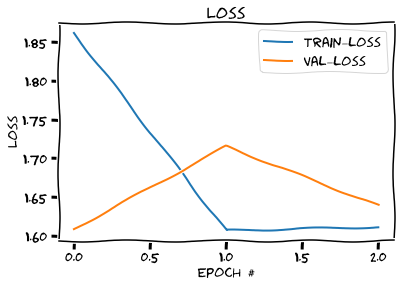

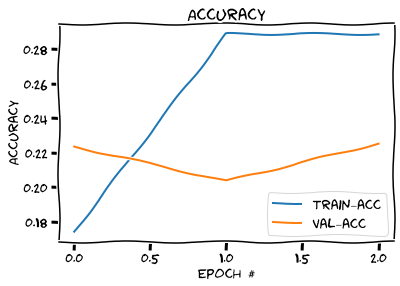

In [20]:
plot_training_loss(history)
plot_training_accuracy(history)

In [21]:
model.save('warmup.h5')

### Fine tune CNN

In [24]:
model.layers[1].trainable = True

model.compile(loss="sparse_categorical_crossentropy", metrics=["acc"],
                     optimizer=tf.keras.optimizers.Adam(1e-5))

history = model.fit(training_ds,
                 validation_data=testing_ds,
                 epochs=35,
                 callbacks=[early_stopper])

Epoch 1/35
6/6 [==============================] - 6s 1s/step - loss: 1.6236 - acc: 0.2670 - val_loss: 1.5824 - val_acc: 0.2727
Epoch 2/35
6/6 [==============================] - 5s 803ms/step - loss: 1.5492 - acc: 0.3106 - val_loss: 1.5674 - val_acc: 0.2564
Epoch 3/35
6/6 [==============================] - 5s 790ms/step - loss: 1.4850 - acc: 0.3597 - val_loss: 1.5692 - val_acc: 0.2764
Epoch 4/35
6/6 [==============================] - 5s 813ms/step - loss: 1.4370 - acc: 0.4005 - val_loss: 1.5793 - val_acc: 0.2873
Epoch 00004: early stopping


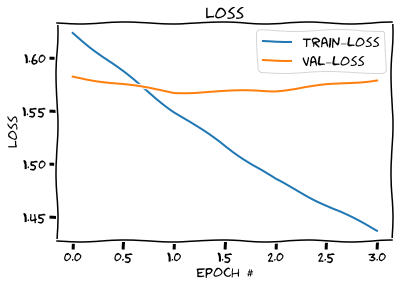

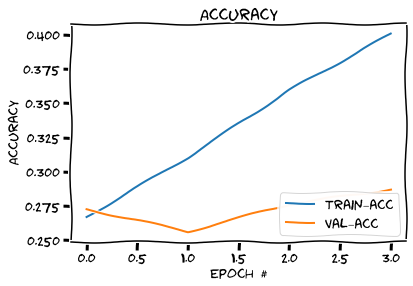

In [25]:
plot_training_loss(history)
plot_training_accuracy(history)

# Training with Augmentation


### Augmentation

In [26]:
# Configs
CROP_SIZE = 224
MIN_SCALE = 0.5
MAX_SCALE = 1.

# Experimental options
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.map_vectorization.enabled = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_deterministic = False
options.experimental_threading.max_intra_op_parallelism = 1

In [27]:
@tf.function
def scale_image(image, label):
	image = tf.image.convert_image_dtype(image, tf.float32)
	return (image, label)

@tf.function
def random_apply(func, x, p):
	return tf.cond(
		tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
				tf.cast(p, tf.float32)),
		lambda: func(x),
		lambda: x)
 
@tf.function
def random_resize_crop(image, label):
  # Conditional resizing
  image = tf.image.resize(image, (260, 260))
  # Get the crop size for given min and max scale
  size = tf.random.uniform(shape=(1,), minval=MIN_SCALE*260,
		          maxval=MAX_SCALE*260, dtype=tf.float32)
  size = tf.cast(size, tf.int32)[0]
  # Get the crop from the image
  crop = tf.image.random_crop(image, (size,size,3))
  crop_resize = tf.image.resize(crop, (CROP_SIZE, CROP_SIZE))
  
  return crop_resize, label

@tf.function
def tie_together(image, label):
  # Scale the pixel values
  image, label = scale_image(image , label)
  # random horizontal flip
  image = random_apply(tf.image.random_flip_left_right, image, p=0.5)
  # Random resized crops
  image, label = random_resize_crop(image, label)
  
  return image, label

In [28]:
trainloader = (
	train_ds
	.shuffle(1024)
	.map(tie_together, num_parallel_calls=AUTO)
	.batch(BATCH_SIZE)
	.prefetch(AUTO)
)

trainloader = trainloader.with_options(options)

### Warmup

In [29]:
model = get_training_model()

model.compile(loss="sparse_categorical_crossentropy", metrics=["acc"],
                     optimizer='adam')

history = model.fit(trainloader,
                 validation_data=testing_ds,
                 epochs=35,
                 callbacks=[early_stopper])

Epoch 1/35
6/6 [==============================] - 3s 571ms/step - loss: 1.6355 - acc: 0.3079 - val_loss: 1.6075 - val_acc: 0.2345
Epoch 2/35
6/6 [==============================] - 3s 433ms/step - loss: 1.5842 - acc: 0.2807 - val_loss: 1.6234 - val_acc: 0.2145
Epoch 3/35
6/6 [==============================] - 3s 460ms/step - loss: 1.5638 - acc: 0.3025 - val_loss: 1.5892 - val_acc: 0.2618
Epoch 4/35
6/6 [==============================] - 3s 457ms/step - loss: 1.5581 - acc: 0.3488 - val_loss: 1.5636 - val_acc: 0.2927
Epoch 5/35
6/6 [==============================] - 3s 438ms/step - loss: 1.5415 - acc: 0.3297 - val_loss: 1.5805 - val_acc: 0.2636
Epoch 6/35
6/6 [==============================] - 3s 461ms/step - loss: 1.5433 - acc: 0.3134 - val_loss: 1.5574 - val_acc: 0.2818
Epoch 7/35
6/6 [==============================] - 3s 468ms/step - loss: 1.5305 - acc: 0.3351 - val_loss: 1.5416 - val_acc: 0.3164
Epoch 8/35
6/6 [==============================] - 3s 444ms/step - loss: 1.5247 - acc: 0.34

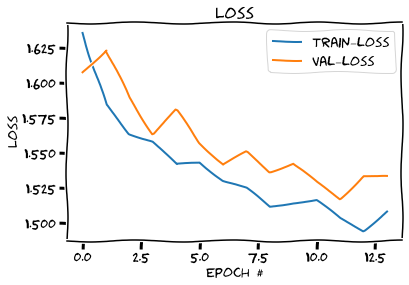

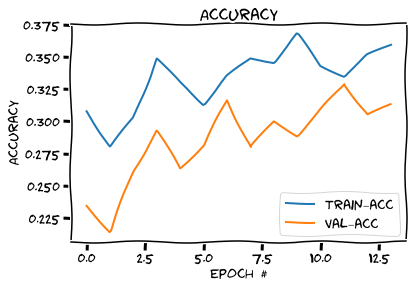

In [30]:
plot_training_loss(history)
plot_training_accuracy(history)

In [31]:
model.save('warmup_augmentation.h5')

### Fine tune CNN

In [32]:
model.layers[1].trainable = True

model.compile(loss="sparse_categorical_crossentropy", metrics=["acc"],
                     optimizer=tf.keras.optimizers.Adam(1e-5))

history = model.fit(trainloader,
                 validation_data=testing_ds,
                 epochs=35,
                 callbacks=[early_stopper])

Epoch 1/35
6/6 [==============================] - 6s 929ms/step - loss: 1.6416 - acc: 0.2861 - val_loss: 1.5442 - val_acc: 0.3127
Epoch 2/35
6/6 [==============================] - 5s 788ms/step - loss: 1.5450 - acc: 0.3161 - val_loss: 1.5548 - val_acc: 0.2764
Epoch 3/35
6/6 [==============================] - 5s 811ms/step - loss: 1.5332 - acc: 0.3379 - val_loss: 1.5315 - val_acc: 0.3364
Epoch 4/35
6/6 [==============================] - 5s 799ms/step - loss: 1.5151 - acc: 0.3433 - val_loss: 1.5325 - val_acc: 0.3036
Epoch 5/35
6/6 [==============================] - 5s 821ms/step - loss: 1.5024 - acc: 0.3624 - val_loss: 1.5413 - val_acc: 0.2855
Epoch 00005: early stopping


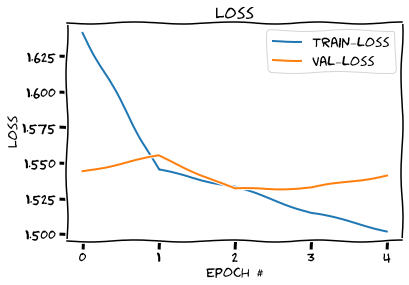

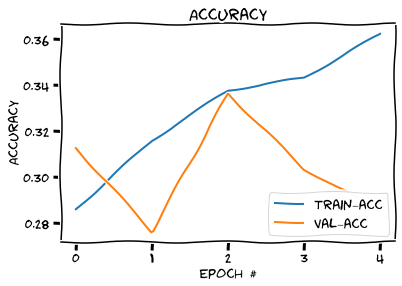

In [33]:
plot_training_loss(history)
plot_training_accuracy(history)

In [34]:
model.save('finetune_augmentation.h5')